In [24]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.io as io
import time
import json
from scipy.sparse.linalg import svds
from sklearn import preprocessing
import matplotlib.pyplot as pyplot

In [2]:
# read interactions file
train_final = pd.read_csv('../../input/train_final.csv', sep = '\t')
train_final['interaction'] = 1.0
train_final = train_final.sort_values(['playlist_id', 'track_id'], ascending=[True, True])
numberInteractions = train_final.shape[0]
print(train_final.iloc[:20,])

        playlist_id  track_id  interaction
770769         7569    162463          1.0
925571         7569    421750          1.0
912580         7569    795606          1.0
852833         7569   1195736          1.0
287048         7569   2227105          1.0
92449          7569   2634448          1.0
519471         7569   2654612          1.0
173680         7569   2693660          1.0
903004         7569   2861386          1.0
863056         7614    415173          1.0
278077         7614   1384962          1.0
394480         7614   1609224          1.0
615615         7614   1614974          1.0
328664         7614   1714787          1.0
377085         7614   2141817          1.0
83840          7614   2285204          1.0
574199         7614   3361942          1.0
481594         7614   3504896          1.0
300753         7614   3711434          1.0
775317         7614   3833025          1.0


In [3]:
# read target playlists which should receive a recommendation
target_playlists = pd.read_csv('../../input/target_playlists.csv', sep = '\t')
print(target_playlists.head())
print(target_playlists.shape)

   playlist_id
0     10024884
1     10624787
2      4891851
3      4267369
4        65078
(10000, 1)


In [4]:
# read target tracks
target_tracks = list(pd.read_csv('../../input/target_tracks.csv', sep = '\t')['track_id'])
target_tracks

[1316175,
 3885714,
 3091270,
 226759,
 230596,
 1093284,
 2293453,
 2994241,
 2871264,
 93835,
 1123498,
 2374491,
 1074412,
 2853886,
 821071,
 2709648,
 2933818,
 346111,
 66103,
 3638141,
 232971,
 2848406,
 3783264,
 2842670,
 3581982,
 3171591,
 2245591,
 871828,
 2713603,
 1175043,
 106982,
 3102164,
 1553840,
 2057826,
 3557550,
 2363848,
 1253516,
 503539,
 2617340,
 1790258,
 2956696,
 193328,
 303129,
 3608340,
 950730,
 1855305,
 3777248,
 1076555,
 1150702,
 3419354,
 726682,
 465271,
 2602747,
 1762406,
 1605205,
 1759620,
 2021651,
 709968,
 2972914,
 259990,
 1349043,
 3522735,
 1773876,
 2862475,
 106083,
 2820187,
 3612400,
 2881368,
 2083728,
 1935536,
 1585141,
 1444202,
 1248376,
 881160,
 1709123,
 1154985,
 2443976,
 2304545,
 4700754,
 1080646,
 1550729,
 793276,
 4486831,
 3868340,
 2642609,
 548753,
 2168844,
 5546,
 472924,
 1604514,
 3013929,
 2213950,
 717927,
 1245649,
 3250648,
 8287,
 881469,
 3242407,
 132362,
 2466040,
 2433491,
 426884,
 2843330,
 990

In [5]:
# read tracks_final which should receive a recommendation
tracks_final = pd.read_csv('../../input/tracks_final.csv', sep = '\t')
print(tracks_final.head())
print(tracks_final.shape)

   track_id  artist_id  duration  playcount   album  \
0   2972914        144    224000       49.0     [7]   
1   2750239        246    157000        1.0     [8]   
2   1550729        144    217000      554.0     [9]   
3   2169950        144    207000      200.0     [9]   
4   1903709        144    198000        5.0  [None]   

                                     tags  
0     [54087, 1757, 1718, 116712, 189631]  
1   [189631, 3424, 177424, 46208, 205245]  
2   [54087, 109806, 46869, 183258, 54337]  
3  [54087, 70618, 207003, 109806, 116712]  
4   [54087, 81223, 116712, 215342, 71028]  
(100000, 6)


In [6]:
playlist_id = list(train_final['playlist_id'])
track_id = list(train_final['track_id'])
interaction = list(train_final['interaction'])
print(playlist_id[:10])
print(track_id[:10])
print(interaction[:10])

[7569, 7569, 7569, 7569, 7569, 7569, 7569, 7569, 7569, 7614]
[162463, 421750, 795606, 1195736, 2227105, 2634448, 2654612, 2693660, 2861386, 415173]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [7]:
playlist_id_unique = list(set(playlist_id))
track_id_unique = list(set(track_id))
playlist_id_unique.sort()
playlist_id_unique = pd.DataFrame(playlist_id_unique)
playlist_id_unique.reset_index(level=0, inplace=True)
playlist_id_unique.columns = ['index_playlist', 'playlist_id']
#track_id_unique.sort()
track_id_unique = pd.DataFrame(track_id_unique)
track_id_unique.reset_index(level=0, inplace=True)
track_id_unique.columns = ['index_track', 'track_id']
print(track_id_unique.head())
print(playlist_id_unique.head())

   index_track  track_id
0            0   1048594
1            1   2359314
2            2   1835030
3            3   3670041
4            4   1048604
   index_playlist  playlist_id
0               0         7569
1               1         7614
2               2         7641
3               3         7692
4               4         7816


In [8]:
train_intermediate = train_final.merge(playlist_id_unique, how='inner', on='playlist_id')
train_index = train_intermediate.merge(track_id_unique, how='inner', on='track_id')
train_index = train_index.sort_values(['playlist_id', 'track_id'], ascending=[True, True])
train_index

,playlist_id,track_id,interaction,index_playlist,index_track
0,7569,162463,1.0,0,62358
87,7569,421750,1.0,0,60999
116,7569,795606,1.0,0,3009
125,7569,1195736,1.0,0,55563
195,7569,2227105,1.0,0,49116
198,7569,2634448,1.0,0,4229
241,7569,2654612,1.0,0,12230
253,7569,2693660,1.0,0,26479
263,7569,2861386,1.0,0,93022
298,7614,415173,1.0,1,58038


In [9]:
tracks_final = tracks_final.merge(track_id_unique, how='inner', on='track_id')
tracks_final

,track_id,artist_id,duration,playcount,album,tags,index_track
0,2972914,144,224000,49.0,[7],"[54087, 1757, 1718, 116712, 189631]",33328
1,2750239,246,157000,1.0,[8],"[189631, 3424, 177424, 46208, 205245]",48728
2,1550729,144,217000,554.0,[9],"[54087, 109806, 46869, 183258, 54337]",93035
3,2169950,144,207000,200.0,[9],"[54087, 70618, 207003, 109806, 116712]",26668
4,1903709,144,198000,5.0,[None],"[54087, 81223, 116712, 215342, 71028]",25248
5,2256817,144,218000,2.0,[9],"[54087, 109806, 189631, 49166, 116712]",61032
6,2561768,928,223000,249.0,[26],"[50764, 4425, 11056, 205245, 81223]",79968
7,474864,928,193000,73.0,[22],"[205245, 81223, 11056, 267, 3982]",84079
8,1378455,928,304000,73.0,[22],"[11056, 205245, 81223, 189631, 84597]",24944
9,1523190,928,206000,10.0,[22],"[205245, 11056, 81223, 4425, 189631]",83966


In [10]:
index_playlist = list(train_index['index_playlist'])
index_track = list(train_index['index_track'])
interaction = list(train_index['interaction'])
print(index_playlist[:10])
print(index_track[:10])
print(interaction[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[62358, 60999, 3009, 55563, 49116, 4229, 12230, 26479, 93022, 58038]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [11]:
URM_all = sps.coo_matrix((interaction, (index_playlist, index_track)))
URM_all = URM_all.tocsr()
URM_all

<45649x99999 sparse matrix of type '<class 'numpy.float64'>'
	with 1040522 stored elements in Compressed Sparse Row format>

In [13]:
tracks_final['tags'] = tracks_final.tags.apply(json.loads)

In [14]:
tags_list = []
for index, row in tracks_final.iterrows():
    if len(row['tags']) != 0:
        for i in row['tags']:
            tags_list.append([row['index_track'], i, 1])

In [15]:
tags_list = pd.DataFrame(tags_list)
tags_list.columns = ['index_track', 'tag', 'interaction']
tags_list

,index_track,tag,interaction
0,33328,54087,1
1,33328,1757,1
2,33328,1718,1
3,33328,116712,1
4,33328,189631,1
5,48728,189631,1
6,48728,3424,1
7,48728,177424,1
8,48728,46208,1
9,48728,205245,1


In [16]:
track_list = list(tags_list['index_track'])
tag_list = list(tags_list['tag'])
interaction_list = list(tags_list['interaction'])

In [17]:
le = preprocessing.LabelEncoder()
le.fit(tag_list)
taglist_icm = le.transform(tag_list)
print(taglist_icm.max())
print(type(taglist_icm))


31897
<class 'numpy.ndarray'>


In [19]:
ICM = sps.coo_matrix((interaction_list, (track_list, taglist_icm)))
ICM = ICM.tocsr()

## Let's take a look at the ICM

In [21]:
features_per_item = (ICM > 0).sum(axis=1)
items_per_feature = (ICM > 0).sum(axis=0)

print(features_per_item.shape)
print(items_per_feature.shape)

(99999, 1)
(1, 31898)


In [22]:
features_per_item = np.array(features_per_item).squeeze()
items_per_feature = np.array(items_per_feature).squeeze()

print(features_per_item.shape)
print(items_per_feature.shape)

(99999,)
(31898,)


In [23]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

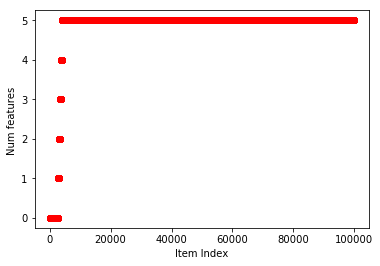

In [25]:
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

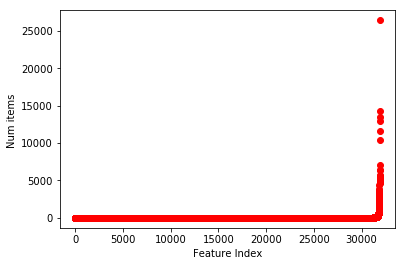

In [26]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

## We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [37]:
train_test_split = 0.80

numInteractions = URM_all.nnz


train_mask = np.random.choice([True,False], numInteractions, [train_test_split, 1-train_test_split])

index_playlist = np.array(index_playlist)
index_track = np.array(index_track)
interaction = np.array(interaction)

index_playlist_unique = list(set(index_playlist))
index_track_unique = list(set(index_track))

URM_train = sps.coo_matrix((interaction[train_mask], (index_playlist[train_mask], index_track[train_mask])))
URM_train = URM_train.tocsr()

test_mask = np.logical_not(train_mask)

URM_test = sps.coo_matrix((interaction[test_mask], (index_playlist[test_mask], index_track[test_mask])))
URM_test = URM_test.tocsr()

def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for i,user_id in  enumerate(index_playlist_unique):
        
        if i % 500 == 0:
            print("User %d of %d" % (i, len(index_playlist_unique)))

        relevant_items = URM_test[user_id].indices
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP))

In [28]:
class BasicItemKNNRecommender(object):
    """ ItemKNN recommender with cosine similarity and no shrinkage"""

    def __init__(self, URM, k=50, shrinkage=100, similarity='cosine'):
        self.dataset = URM
        self.k = k
        self.shrinkage = shrinkage
        self.similarity_name = similarity
        if similarity == 'cosine':
            self.distance = Cosine(shrinkage=self.shrinkage)
        elif similarity == 'pearson':
            self.distance = Pearson(shrinkage=self.shrinkage)
        elif similarity == 'adj-cosine':
            self.distance = AdjustedCosine(shrinkage=self.shrinkage)
        else:
            raise NotImplementedError('Distance {} not implemented'.format(similarity))

    def __str__(self):
        return "ItemKNN(similarity={},k={},shrinkage={})".format(
            self.similarity_name, self.k, self.shrinkage)

    def fit(self, X):
        item_weights = self.distance.compute(X)
        
        item_weights = check_matrix(item_weights, 'csr') # nearly 10 times faster
        print("Converted to csr")
        
        # for each column, keep only the top-k scored items
        # THIS IS THE SLOW PART, FIND A BETTER SOLUTION        
        values, rows, cols = [], [], []
        nitems = self.dataset.shape[1]
        for i in range(nitems):
            if (i % 10000 == 0):
                print("Item %d of %d" % (i, nitems))
                
            this_item_weights = item_weights[i,:].toarray()[0]
            top_k_idx = np.argsort(this_item_weights) [-self.k:]
                        
            values.extend(this_item_weights[top_k_idx])
            rows.extend(np.arange(nitems)[top_k_idx])
            cols.extend(np.ones(self.k) * i)
        self.W_sparse = sps.csc_matrix((values, (rows, cols)), shape=(nitems, nitems), dtype=np.float32)

    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.dataset[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        # rank items
        ranking = scores.argsort()[::-1]
        if exclude_seen:
            ranking = self._filter_seen(user_id, ranking)
            
        return ranking[:at]
    
    def _filter_seen(self, user_id, ranking):
        user_profile = self.dataset[user_id]
        seen = user_profile.indices
        unseen_mask = np.in1d(ranking, seen, assume_unique=True, invert=True)
        return ranking[unseen_mask]

## We need to define Cosine similarity:

In [29]:
def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, sps.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, sps.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, sps.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, sps.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, sps.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, sps.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, sps.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)

In [32]:
class ISimilarity(object):
    """Abstract interface for the similarity metrics"""

    def __init__(self, shrinkage=10):
        self.shrinkage = shrinkage

    def compute(self, X):
        pass


class Cosine(ISimilarity):
    def compute(self, X):
        # convert to csc matrix for faster column-wise operations
        X = check_matrix(X, 'csc', dtype=np.float32)

        # 1) normalize the columns in X
        # compute the column-wise norm
        # NOTE: this is slightly inefficient. We must copy X to compute the column norms.
        # A faster solution is to  normalize the matrix inplace with a Cython function.
        Xsq = X.copy()
        Xsq.data **= 2
        norm = np.sqrt(Xsq.sum(axis=0))
        norm = np.asarray(norm).ravel()
        norm += 1e-6
        # compute the number of non-zeros in each column
        # NOTE: this works only if X is instance of sparse.csc_matrix
        col_nnz = np.diff(X.indptr)
        # then normalize the values in each column
        X.data /= np.repeat(norm, col_nnz)
        print("Normalized")

        # 2) compute the cosine similarity using the dot-product
        dist = X * X.T
        print("Computed")
        
        # zero out diagonal values
        dist = dist - sps.dia_matrix((dist.diagonal()[sp.newaxis, :], [0]), shape=dist.shape)
        print("Removed diagonal")
        
        # and apply the shrinkage
        if self.shrinkage > 0:
            dist = self.apply_shrinkage(X, dist)
            print("Applied shrinkage")    
        
        return dist

    def apply_shrinkage(self, X, dist):
        # create an "indicator" version of X (i.e. replace values in X with ones)
        X_ind = X.copy()
        X_ind.data = np.ones_like(X_ind.data)
        # compute the co-rated counts
        co_counts = X_ind * X_ind.T
        # remove the diagonal
        co_counts = co_counts - sps.dia_matrix((co_counts.diagonal()[sp.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        co_counts_shrink = co_counts.copy()
        co_counts_shrink.data += self.shrinkage
        co_counts.data /= co_counts_shrink.data
        dist.data *= co_counts.data
        return dist

## Test it

In [33]:
rec = BasicItemKNNRecommender(URM=URM_train, shrinkage=0.0, k=50)
rec.fit(ICM)

Normalized
Computed
Removed diagonal
Converted to csr
Item 0 of 99999
Item 10000 of 99999
Item 20000 of 99999
Item 30000 of 99999
Item 40000 of 99999
Item 50000 of 99999
Item 60000 of 99999
Item 70000 of 99999
Item 80000 of 99999
Item 90000 of 99999


In [35]:
for user_id in index_playlist_unique[0:10]:
    print(rec.recommend(user_id, at=5))

[45733 21878 42265 31621 11294]
[98643 16489 24887 14799 52721]
[35204 35825 69285 56319 98517]
[71766 72490 81982   347 90673]
[34999 51693 90952 71061 70964]
[68809  3484 64583 90907 31292]
[99998 33348 33326 33327 33328]
[87614 56228 30305 99971  2664]
[99998 33348 33326 33327 33328]
[68741 40303 22758 89872 74063]


In [38]:
evaluate_algorithm(URM_test, rec)

User 0 of 45649
User 500 of 45649
User 1000 of 45649
User 1500 of 45649
User 2000 of 45649
User 2500 of 45649
User 3000 of 45649
User 3500 of 45649
User 4000 of 45649
User 4500 of 45649
User 5000 of 45649
User 5500 of 45649
User 6000 of 45649
User 6500 of 45649
User 7000 of 45649
User 7500 of 45649
User 8000 of 45649
User 8500 of 45649
User 9000 of 45649
User 9500 of 45649
User 10000 of 45649
User 10500 of 45649
User 11000 of 45649
User 11500 of 45649
User 12000 of 45649
User 12500 of 45649
User 13000 of 45649
User 13500 of 45649
User 14000 of 45649
User 14500 of 45649
User 15000 of 45649
User 15500 of 45649
User 16000 of 45649
User 16500 of 45649
User 17000 of 45649
User 17500 of 45649
User 18000 of 45649
User 18500 of 45649
User 19000 of 45649
User 19500 of 45649
User 20000 of 45649
User 20500 of 45649
User 21000 of 45649
User 21500 of 45649
User 22000 of 45649
User 22500 of 45649
User 23000 of 45649
User 23500 of 45649
User 24000 of 45649
User 24500 of 45649
User 25000 of 45649
User

In [ ]:
rec_s = BasicItemKNNRecommender(URM=URM_train, shrinkage=10.0, k=50)
rec_s.fit(ICM)
evaluate_algorithm(URM_test, rec_s)

Normalized
Computed
Removed diagonal
Applied shrinkage
Converted to csr
Item 0 of 99999
Item 10000 of 99999
Item 20000 of 99999
Item 30000 of 99999
Item 40000 of 99999
Item 50000 of 99999
Item 60000 of 99999
Item 70000 of 99999
Item 80000 of 99999
